In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import spacy
import emoji
import nltk
import torch
import torch.nn as nn
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize , RegexpTokenizer
from nltk.stem import SnowballStemmer
import qalsadi.lemmatizer
from fuzzywuzzy import fuzz,process
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
#from transformers import BertModel, BertTokenizer
from collections import defaultdict
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
from transformers import DistilBertTokenizer, DistilBertModel,AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df0=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/resaux_comments.xlsx")
df1=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/facebook (4).xlsx")
df2=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/fb_comments.xlsx")
df3=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/hainer_ranim.xlsx")
df4=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/neutre_mehdi.xlsx")
df5=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/newest.xlsx")
df6=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/hateonly_mehdi.xlsx")

In [4]:
df = pd.concat([df0, df6, df2, df3,df4,df5], axis=0, ignore_index=True)

In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df

,comments,class
0,Rana m3ak hbibi PHANTOME🔥🔥🔥 Djezzy nebghaw rad,0.0
1,تلفون عندي مايحملهاش ممكن تتبرعولي بتلفون كهدي...,0.0
2,كفاش هاذي,0.0
3,@dina_burghezilor @abdelali_harafa10 @chouna-ben,0.0
4,كيفاه عرفتو بلي زاهية ليوم بتطياح,-1.0
...,...,...
18946,Djezzy,0.0
18947,المودام تاني يديه معاه,0.0
18948,❤️,0.0
18949,شكون هدا ...مدايرين به حكاية ...ناس اي تحوس عل...,0.0


In [128]:
df.to_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/dataset.xlsx")

In [6]:
df=df.dropna(subset = ['comments'])

In [7]:
df1=df1.dropna(subset = ['comments'])

In [8]:
df['comments'].isna().sum()

0

In [9]:
df['class'].value_counts()

 0.0    13930
 1.0     2798
-1.0     1687
Name: class, dtype: int64

*** 
---
___

## <span style='font-family:Georgia'> Preprocessing of Text.

### <span style='font-family:serif'> Function to Remove Emojis

In [10]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

### <span style='font-family:serif'> Removing stop words

In [11]:
# Load stopwords for each language
with open('Algerian-Arabic-stop-words.txt', 'r', encoding='utf-8') as f:
    stop_words_ar_dz = set([line.strip() for line in f])
stop_words_en = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french'))
# Create a custom tokenizer for Arabic words
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
# Define a function to remove stop words from a text
def remove_stopwords(text):
    words = tokenizer.tokenize(text)
    words_filtered = []
    for word in words:
        if word not in stop_words_ar_dz and word not in stop_words_en and word not in stop_words_fr:
            words_filtered.append(word)
    return ' '.join(words_filtered)


### <span style='font-family:serif'> Fucntion to remove special characters, URLs, duplicated letters, punctuations

In [12]:
# Define a function to perform the text cleaning operations
def clean_text(text):
    text = re.sub(r'[\r\n]+', ' ', text).lower()  
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #URLs
    #text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation marks 
    text = re.sub(r'\b\d+\b', '', text) # Remove only standalone numbers
    text = re.sub(r'[@#&$]\w+', '', text)  # Remove special characters
    text = re.sub(r'(\w{1})(\1{2,})', r'\1', text) # remove duplicated letters
    return text

In [218]:
print(clean_text('ان.من.نفلكسي.لا.1500.ولا.1000.الف.لان.وينروح.انقبض.الانترانت.بطل.'))

ان من نفلكسي لا  ولا  الف لان وينروح انقبض الانترانت بطل 


### <span style='font-family:serif'> Function to remove mutiple sequence spaces

In [13]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

### <span style='font-family:serif'> Function for language detection

In [ ]:
'''DetectorFactory.seed = 0  # Set the random seed for reproducibility
# Set the detection threshold to 0.7
DetectorFactory.threshold = 0.7
def lang_det(texte):
    try:
        langs = detect_langs(texte)
        for lang in langs:
            if lang.prob >= 0.999994:
                langage = lang.lang
            else:
                langage = 'dz'
        if langage not in ['en','fr']:
            langage = 'dz'
    except LangDetectException:
        langage = 'dz'
    
    return langage'''

- downloading and saving the model papluca/xlm-roberta-base-language-detection from huggung face

In [18]:
#model_name = "papluca/xlm-roberta-base-language-detection"
#model = AutoModelForSequenceClassification.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#Save the model and tokenizer to a directory
#model.save_pretrained('saved_model_langdetec')
#tokenizer.save_pretrained('saved_model_langdetec')

C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\BIGNETWORK\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [14]:
#load the model and tokenizer 
model_lang = AutoModelForSequenceClassification.from_pretrained('saved_model_langdetec')
tokenizer_lang = AutoTokenizer.from_pretrained('saved_model_langdetec')

In [15]:
classifier = pipeline("text-classification", model=model_lang, tokenizer=tokenizer_lang)

def lang_det(texte):
    
    result = classifier(texte)
    
    if result[0]["score"] >= 0.2:
        langage = result[0]["label"]
    else:
        langage = 'dz'
    if langage not in ['en','fr']:
        langage = 'dz'
    
    
    return langage

In [99]:
print(lang_det('Je suis MORTEEEE 😂😂😂😂😂😂😂'))

fr


### <span style='font-family:serif'> Fonction that translate from Arabizi to Algerian Arabic alphabet using mapping dictionary

In [16]:
# Define the mapping dictionary
mapping = {
    'ai':'ي','ae':'ع','au': 'و','tion':'صيو', 'gh':'غ', 'kh':'خ','sh':'ش','dj':'ج','zz': 'ز',
    'ch':'ش','ga': 'ڨ','go': 'ڨ','g': 'ج', 'h': 'ه', 'i': 'ي', 'j': 'ج', 'k': 'ك', 'l': 'ل','e': '', 'f': 'ف',
    'm': 'م', 'n': 'ن', 'ou': 'و','a': '','c':'ك', 'o': '', 'p': 'ب', 'q': 'ك', 'r': 'ر','d': 'د',
    's': 'س', 't': 'ت', 'u': '', 'v': 'ڥ', 'w': 'و', 'x': 'كس','b': 'ب','6':'ط',
    'y': 'ي', 'z': 'ز','9':'ق','7':'ح','é':'','3':'ع','1':'يا','5':'خ','è':''
}
# Define the translation function
def arabizi_to_arabic(text):

    '''pattern = '[aeêiouAEIOU]'
    # remplacement des voyelles par une chaîne vide
    text = re.sub(pattern, '', text)'''
    # Replace each Arabizi letter with its corresponding Arabic alphabet dialect letter
    for letter, value in mapping.items():
        
        text = re.sub(letter, value, text)
    return text


# Example usage
arabizi_text = "djezzy m3a ba3d ne9edro n5arjokom mn ra7mt rabi 😑"
arabic_text = arabizi_to_arabic(arabizi_text)
print(arabic_text)

جزي مع بعد نقدر نخرجكم من رحمت ربي 😑


### <span style='font-family:serif'> Function to  apply stemming to words

In [17]:
def stem_words(text):
    language = lang_det(text)
    stemmer = None
    words = tokenizer.tokenize(text)
    if language == 'dz':
        text=arabizi_to_arabic(text)
        stemmed_text = text
    elif language == 'fr':
        stemmer = SnowballStemmer('french')
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_text = ' '.join(stemmed_words)
    elif language == 'en':
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_text = ' '.join(stemmed_words)
    else:
        return text # No stemmer available for this language
    
    return stemmed_text

In [102]:
print(stem_words('eating'))

eat


### <span style='font-family:serif'> Function to apply lemmatization to words

In [18]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BIGNETWORK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BIGNETWORK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:

nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')
def lemmatize(text):
    # Tokenize the text
    words = tokenizer.tokenize(text)

    # Define lemmatizer for each language
    lemma_dz = qalsadi.lemmatizer.Lemmatizer()
    # Lemmatize each word in the text
    lemmatized_words = []
    lang = lang_det(text)
    if lang =='en':
        doc = nlp_en(text)
        for token in doc:
            lemma = token.lemma_
            lemmatized_words.append(lemma)
    elif lang =='fr':
        doc = nlp_fr(text)
        for token in doc:
            lemma = token.lemma_
            lemmatized_words.append(lemma)
    elif lang =='dz':
        for word in words:
            lemma = lemma_dz.lemmatize(word)
            lemmatized_words.append(lemma)
    
    # Join the lemmatized words to form the lemmatized text
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

In [224]:
print(lemmatize('normalement lorsque le nombre d''abonnés augmente ils doivent créer d''autres sites'))

normalement lorsque le nombre dabonner augmenter il devoir créer dautre site


In [19]:
import mtranslate as mt
english_text = 'women should stay at home and die'
arabic_text = mt.translate(english_text, 'ar')
print(arabic_text)

french_text = 'vous pouver me repondre au prv'
arabic_text = mt.translate(french_text, 'ar')
print(arabic_text)


يجب أن تبقى المرأة في المنزل وتموت
يمكنك الرد علي في prv


### <span style='font-family:serif'> Function to Preprocess the text by applying all above functions

In [20]:
def preprocess1(text):
    text = strip_emoji(text)
    text = clean_text(text)
    text = remove_mult_spaces(text)
    return text


In [21]:
def preprocess2(text):
    text = stem_words(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

In [104]:
if df['comments'].dtype == 'object':
    df['comments_clean'] = df['comments'].apply(preprocess1)

C:\Users\BIGNETWORK\AppData\Local\Temp\ipykernel_12276\1939872065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments_clean'] = df['comments'].apply(preprocess1)


In [22]:
if df1['comments'].dtype == 'object':
    df1['comments_clean'] = df1['comments'].apply(preprocess1)

In [ ]:
df['comments_clean'].replace('', np.nan, inplace=True)
missing_values = df[df['comments_clean'].isnull()]
#df=df.dropna(subset = ['comments_clean'])
len(missing_values)

In [23]:
df1['comments_clean'].replace('', np.nan, inplace=True)
missing_values = df1[df1['comments_clean'].isnull()]
#df=df.dropna(subset = ['comments_clean'])
len(missing_values)

1

In [229]:
df=df.dropna(subset = ['comments_clean'])

In [24]:
df1=df1.dropna(subset = ['comments_clean'])

,comments,class,comments_corr
0,عوضلي المدة لي قطعتلي فيها انترنات .كنكسيو مسڨ...,0.0,الله لا نربحكم ونتمنالكم كامل الخصارة على الكو...
1,3andi la famille fel Facebook si non ntiya7,1.0,اعدلو الريزو تعكم برك من بعد ساهل و العروض الز...
2,شكون قاللكم بلي رانا متفهمين الوضع؟!!,0.0,افشل شريحة الموبيليس رغم الضغط وهاربة عليكم نت...
3,الله ينعلكم خالو المغتربين في حالهم لي فيهم اك...,-1.0,الفين و عمر واحد ولا راجل ومازلنا نقصو فالتدفق...
4,روحي جيبي شرفك من نظام الأسد يا عجوز,-1.0,منسحقش كدواتكم نسحق انا من ملبحة
...,...,...,...
18950,كل هذه المداخيل من السرقة في العروض وووووووو,1.0,NaN
31,NaN,NaN,نزلت التطبيق وفتحتو قالي أرسل دعوة لخمس أرقام ...
38,NaN,NaN,لماذا لايتم الرد على إنشغالاتنا
126,NaN,NaN,لماذا ليس عندي عروض امتياز


### <span style='font-family:serif'> Regroupement et traitement de fautes d’orthographe

In [ ]:
#df1 = df1.drop('comments_corr', axis=1)

### <span style='font-family:serif'> Function to return the soundex code

In [25]:
# function to get soundex code for a given word
def get_soundex(word):
    soundex_map = {
        'BFPV': '1',
        'CGJKQSXZ': '2',
        'DT': '3',
        'L': '4',
        'MN': '5',
        'R': '6',
        'AEIOUHWY': '0'
    }
    # Step 1: Keep the first letter of the word
    code = word[0].upper()
    
    # Step 2: Replace all remaining letters based on the soundex mapping
    for char in word[1:].upper():
        for key, value in soundex_map.items():
            if char in key:
                code += value
                break
    
    # Step 3: Remove consecutive duplicates except for the first letter
    code = code[0] + ''.join(char for i, char in enumerate(code[1:], start=1) if char != code[i-1] and char != '0')
    
    # Step 4: Pad or truncate to a length of 4 characters
    code = code + '000'
    return code[:4]

In [26]:
# set threshold for similarity score
threshold = 70

# create dictionary to hold fuzzywuzzy scores and their associated words
fuzzy_dict = defaultdict(list)

# create dictionary to hold soundex codes and their associated words
code_dict = defaultdict(list)

# create a list containing all the words in the comments
words_list = [word for comment in df1['comments_clean'] for word in tokenizer.tokenize(comment) if not any('\u0600' <= c <= '\u06FF' for c in word)]

# iterate over all words in the comments
for word in words_list:
    # calculate soundex code for the word
    code = get_soundex(word)
    # add word to the dictionary
    code_dict[code].append(word)

# iterate over all words in code_dict
for code, words in code_dict.items():
    # calculate fuzzywuzzy score for each pair of words
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            score = fuzz.token_sort_ratio(words[i], words[j])
            # if the similarity score is above the threshold, update the fuzzy dictionary
            if score >= threshold:
                fuzzy_dict[words[i]].append((score, words[j]))

# create dictionary to hold word replacements and their associated fuzzywuzzy scores
replace_dict = {}

# iterate over all soundex codes and associated words to find word replacement wich is the one having the maximum score in the cod_dict
for code, words in code_dict.items():
    # skip codes with only one word
    if len(words) == 1:
        continue
    # compare all pairs of words with the same code
    for i in range(len(words)):
        max_score = 0
        max_match = None
        for j in range(i+1, len(words)):
            score = fuzz.token_sort_ratio(words[i], words[j])
            # if the similarity score is above the threshold, update the replacement dictionary
            if score >= threshold:
                if score > max_score:
                    max_score = score
                    max_match = words[j]
        if max_match is not None:
            replace_dict[words[i]] = max_match

# iterate over all comments and replace words with their soundex group words
for i in range(len(df1)):
    try:
        words =tokenizer.tokenize(df1.loc[i,'comments_clean'])
        for j in range(len(words)):
            # check if word is in Arabic script or not
            if any('\u0600' <= c <= '\u06FF' for c in words[j]):
                continue  # skip Arabic words
            # calculate soundex code for the word
            code = get_soundex(words[j])
            # check if the code has associated words
            if code in code_dict:
                # check if the word has a replacement
                if words[j] in replace_dict:
                    words[j] = replace_dict[words[j]]
                else:
                    # check if any of the associated words have a replacement
                    max_score = 0
                    max_match = None
                    for score, match in fuzzy_dict[words[j]]:
                        if match in replace_dict:
                            score = fuzz.token_sort_ratio(words[j], replace_dict[match])
                            if score > max_score:
                                max_score = score
                                max_match = replace_dict[match]
                    if max_match is not None:
                        words[j] = max_match
    except:
        continue
    # join the words back into a string and replace the comment in the dataframe
    df1.loc[i, 'comments_corr'] = ' '.join(words)
#check if 'comments_corr' is NaN and set it to original value
df1['comments_corr'].fillna(df1['comments_clean'], inplace=True)



In [27]:
df1.sample(20)

,comments,class,comments_clean,comments_corr
129,كي نتوما كي لكونيكسيو تاعكم تعيي تقرف,1,كي نتوما كي لكونيكسيو تاعكم تعيي تقرف,كي نتوما كي لكونيكسيو تاعكم تعيي تقرف
182,ناس تنظم مسابقة لربح هواتف واكثر قيمة. وانتم ...,0,ناس تنظم مسابقة لربح هواتف واكثر قيمة وانتم فر...,ناس تنظم مسابقة لربح هواتف واكثر قيمة وانتم فر...
165,لدي طابلات cidea المشكل أن الأنترنت لم تشتغل ف...,0,لدي طابلات cidea المشكل أن الأنترنت لم تشتغل ف...,لدي طابلات cidea المشكل أن الأنترنت لم تشتغل ف...
159,أشحال وانا نفليكسي 1500 دج 40Mo.....,0,أشحال وانا نفليكسي دج 40mo,أشحال وانا نفليكسي دج 40mo
176,علاش رجعتولي لبيس من هايلة الى هايلة بزاف ونحي...,0,علاش رجعتولي لبيس من هايلة الى هايلة بزاف ونحي...,علاش رجعتولي لبيس من هايلة الى هايلة بزاف ونحي...
5,بدراهمنا و مادرتولناش كونكسيو زينا كي دول المج...,1,بدراهمنا و مادرتولناش كونكسيو زينا كي دول المج...,بدراهمنا و مادرتولناش كونكسيو زينا كي دول المج...
154,لماذا لايتم الرد على إنشغالاتنا؟؟؟؟؟؟,0,لماذا لايتم الرد على إنشغالاتنا,لماذا لايتم الرد على إنشغالاتنا
111,شكون نسجله في تطبيق جازي يحصل على 8 GB الانترنت,0,شكون نسجله في تطبيق جازي يحصل على gb الانترنت,شكون نسجله في تطبيق جازي يحصل على gb الانترنت
237,واش المطلوب منا واش نديرو؟,0,واش المطلوب منا واش نديرو,واش المطلوب منا واش نديرو
200,رجعولي ل100ألف,0,رجعولي ل100ألف,رجعولي ل100ألف


In [ ]:
if df['comments'].dtype == 'object':
    df['comments_clean'] = df['comments_corr'].apply(preprocess2)

In [28]:
if df1['comments'].dtype == 'object':
    df1['comments_clean'] = df1['comments_corr'].apply(preprocess2)

### <span style='font-family:serif'> Dealing with Duplicates

In [52]:
df["comments_clean"].duplicated().sum()

1749

In [29]:
df1["comments_clean"].duplicated().sum()

9

In [53]:
df= df.drop_duplicates(subset=["comments_clean"], keep="first")

In [30]:
df1= df1.drop_duplicates(subset=["comments_clean"], keep="first")

#### <span style='font-family:serif'>Duplicates removed

### <span style='font-family:serif'> Tokenization

In [48]:
tokenizer = RegexpTokenizer(r'\w+')
def tokenization(text):
    words=tokenizer.tokenize(text)
    return words

In [ ]:
df['comments_clean']=df['comments_clean'].apply(str)
if df['comments_clean'].dtype == 'object':
    df['comments_list'] = df['comments_clean'].apply(tokenization)


In [ ]:
df1['comments_clean']=df1['comments_clean'].apply(str)
if df1['comments_clean'].dtype == 'object':
    df1['comments_list'] = df1['comments_clean'].apply(tokenization)
df1[df1['class']==0].sample(10)

In [56]:
df=df.dropna(subset = ['class','comments_clean'])

### <span style='font-family:serif'> Checking length of various tweet texts


In [55]:
text_len = []
for text in df.comments_list:
    comment_len = len(text)
    text_len.append(comment_len)
df['text_len'] = text_len

C:\Users\BIGNETWORK\AppData\Local\Temp\ipykernel_6208\2185639929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = text_len


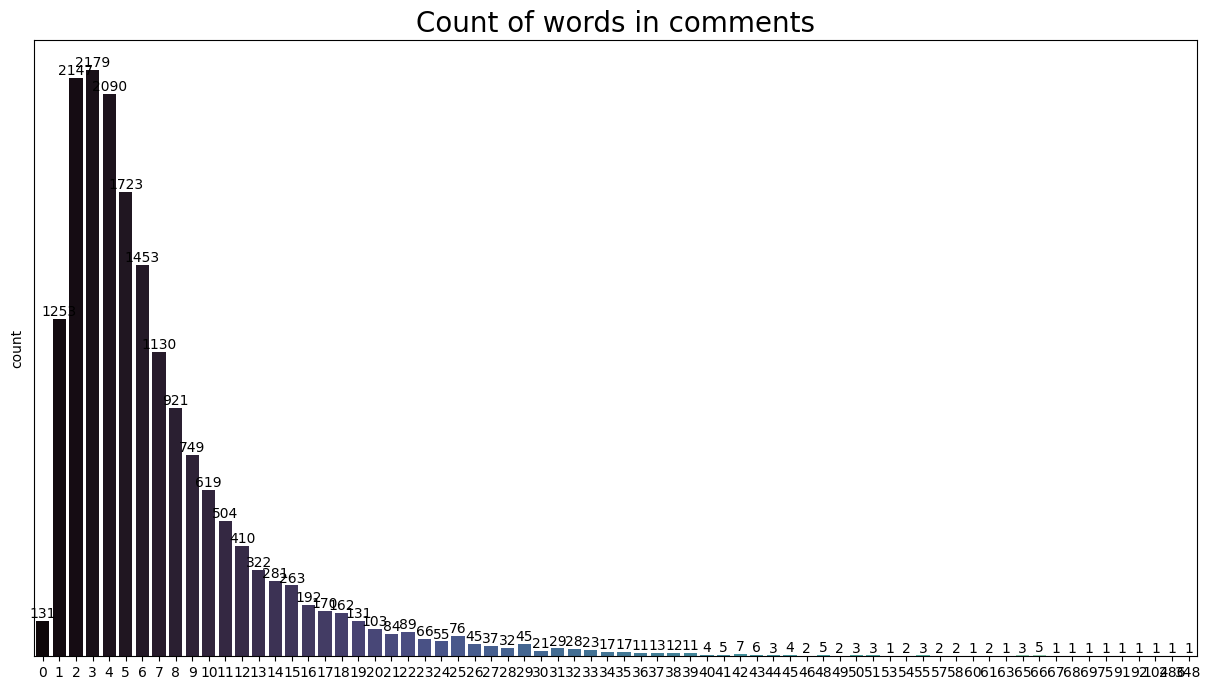

In [56]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=df, palette='mako')
plt.title('Count of words in comments', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()


### <span style='font-family:serif'> Split train dataset into train, validation and test sets

In [123]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [113]:
X,Y = df1['comments_clean'],df1['class']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify =Y, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(159,) (159,) (69,) (69,)


In [83]:
Y= np.asarray(Y)
X= np.asarray(X)

In [125]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)
print(X_train_tf.shape)
print(X_test_tf.shape)

(159, 816)
(69, 816)


In [135]:
train_encodings = tokenizer_(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer_(list(X_test), truncation=True, padding=True, max_length=512)

# Convert data to numpy arrays
X_train_input_ids = np.array(train_encodings['input_ids'])
X_train_attention_masks = np.array(train_encodings['attention_mask'])

X_test_input_ids = np.array(test_encodings['input_ids'])
X_test_attention_masks = np.array(test_encodings['attention_mask'])

# Convert input to PyTorch tensors
X_train_input_ids = torch.tensor(train_encodings['input_ids'])
X_train_attention_masks = torch.tensor(train_encodings['attention_mask'])
X_test_input_ids = torch.tensor(test_encodings['input_ids'])
X_test_attention_masks = torch.tensor(test_encodings['attention_mask'])

# Get word embeddings
train_embeddings = bert(X_train_input_ids, X_train_attention_masks)[0][:, 0, :]
test_embeddings = bert(X_test_input_ids, X_test_attention_masks)[0][:, 0, :]

In [142]:
train_embeddings

tensor([[-0.1178,  0.1320,  0.3211,  ...,  0.2187,  0.0167, -0.1036],
        [-0.0548,  0.0359,  0.4911,  ...,  0.1453, -0.0169, -0.0817],
        [ 0.1305,  0.1047,  0.1949,  ...,  0.3528,  0.1118, -0.1444],
        ...,
        [ 0.0438,  0.0199,  0.4123,  ...,  0.0352, -0.0540, -0.0363],
        [ 0.0318,  0.0049,  0.2826,  ...,  0.2295,  0.0332, -0.1066],
        [-0.0336, -0.0137,  0.6291,  ...,  0.1760,  0.0385, -0.1408]],
       grad_fn=<SliceBackward0>)

In [140]:
y_train_hot=pd.get_dummies(Y)

TypeError: 'tuple' object is not callable

In [66]:
train_encodings = tokenizer_(train_texts, truncation = True, padding = True  )
val_encodings = tokenizer_(val_texts, truncation = True, padding = True )

In [67]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

In [68]:
from transformers import  TFTrainer, TFTrainingArguments

In [43]:
train_encodings = tokenizer_(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer_(list(X_test), truncation=True, padding=True, max_length=512)

# Convert data to numpy arrays
X_train_input_ids = np.array(train_encodings['input_ids'])
X_train_attention_masks = np.array(train_encodings['attention_mask'])

X_test_input_ids = np.array(test_encodings['input_ids'])
X_test_attention_masks = np.array(test_encodings['attention_mask'])

# Convert input to PyTorch tensors
X_train_input_ids = torch.tensor(train_encodings['input_ids'])
X_train_attention_masks = torch.tensor(train_encodings['attention_mask'])
X_test_input_ids = torch.tensor(test_encodings['input_ids'])
X_test_attention_masks = torch.tensor(test_encodings['attention_mask'])

# Get word embeddings
train_embeddings = bert(X_train_input_ids, X_train_attention_masks)[0][:, 0, :]
test_embeddings = bert(X_test_input_ids, X_test_attention_masks)[0][:, 0, :]

In [36]:
train_text, temp_text, train_labels, temp_labels = train_test_split(X, Y, 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=Y)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

#### <span style='font-family:serif'>loading bert model

In [116]:
#model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
#Save the model and tokenizer to a directory
#model.save_pretrained('saved_model_dist_tf')
#tokenizer.save_pretrained('saved_model_dist_tf')

C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\BIGNETWORK\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
All TF 2.0 model weights were used when ini

In [40]:
# Load the model and tokenizer from the directory
bert = DistilBertModel.from_pretrained('saved_model_dist')
tokenizer_ = DistilBertTokenizer.from_pretrained('saved_model_dist')

In [41]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer_.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

{'input_ids': [[101, 10531, 10124, 169, 10347, 10976, 13192, 69635, 34108, 102, 0], [101, 11951, 11337, 13435, 118, 91695, 169, 10347, 10976, 13192, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


- Tokenization

<AxesSubplot: >

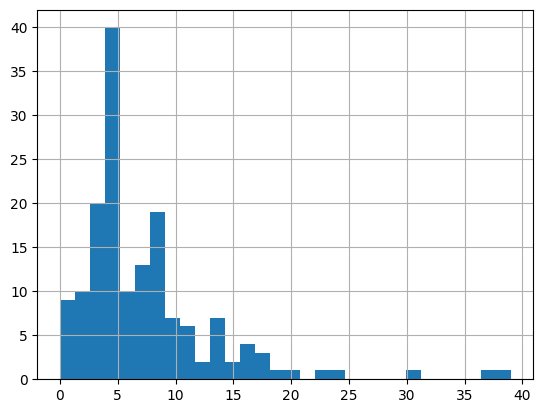

In [42]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [43]:
max_seq_len = 10

In [44]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer_.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer_.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer_.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## <span style='font-family:serif'>Convert Integer Sequences to Tensors

In [45]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## <span style='font-family:serif'>Create DataLoaders

In [46]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## <span style='font-family:serif'>Freeze BERT Parameters

In [153]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## <span style='font-family:serif'>Define Model Architecture

In [162]:
print(sent_id)

{'input_ids': [[101, 10531, 10124, 169, 10347, 10976, 13192, 69635, 34108, 102, 0], [101, 11951, 11337, 13435, 118, 91695, 169, 10347, 10976, 13192, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [196]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model 
      print(self.bert(sent_id, attention_mask=mask)) 
      cls = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x



In [189]:

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

In [190]:

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## <span style='font-family:serif'>Find Class Weights

In [191]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)


print(class_wts)

[5.88888889 0.41732283 2.30434783]


In [192]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [198]:
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[]
    
    for step,batch in enumerate(train_dataloader):
        
        b_input_ids, b_attn_mask, b_labels = tuple(batch)
        
        model.zero_grad()        
                
        outputs = model(b_input_ids, attention_mask=b_attn_mask)
        
        last_hidden_state = outputs.last_hidden_state
        
        logits = classifier(last_hidden_state)
        
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_preds.append(logits)
        
        total_accuracy += flat_accuracy(logits, label_ids)
        
    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_dataloader)
    
    total_preds = np.concatenate(total_preds, axis=0)
    
    return avg_loss, avg_accuracy, total_preds


In [194]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [199]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


TypeError: BERT_Arch.forward() got an unexpected keyword argument 'attention_mask'

In [29]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

# Convert data to numpy arrays
X_train_input_ids = np.array(train_encodings['input_ids'])
X_train_attention_masks = np.array(train_encodings['attention_mask'])

X_test_input_ids = np.array(test_encodings['input_ids'])
X_test_attention_masks = np.array(test_encodings['attention_mask'])

# Convert input to PyTorch tensors
X_train_input_ids = torch.tensor(train_encodings['input_ids'])
X_train_attention_masks = torch.tensor(train_encodings['attention_mask'])
X_test_input_ids = torch.tensor(test_encodings['input_ids'])
X_test_attention_masks = torch.tensor(test_encodings['attention_mask'])

# Get word embeddings
train_embeddings = model(X_train_input_ids, X_train_attention_masks)[0][:, 0, :]
test_embeddings = model(X_test_input_ids, X_test_attention_masks)[0][:, 0, :]

Freeze BERT Parameters

In [31]:
train_embeddings.shape

torch.Size([190, 768])

In [110]:

'''from gensim.models import Word2Vec

# Splitting the sentences into words
sentences = [sentence.split() for sentence in X_train]

# Training the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Generating embeddings for the training set
X_train_embeddings = []
for sentence in sentences:
    sentence_embeddings = []
    for word in sentence:
        if word in model.wv:
            sentence_embeddings.append(model.wv[word])
    if sentence_embeddings:
        X_train_embeddings.append(np.concatenate(sentence_embeddings))

# Generating embeddings for the test set
X_test_embeddings = []
for sentence in [sentence.split() for sentence in X_test]:
    sentence_embeddings = []
    for word in sentence:
        if word in model.wv:
            sentence_embeddings.append(model.wv[word])
    if sentence_embeddings:
        X_test_embeddings.append(np.concatenate(sentence_embeddings))'''


In [59]:
train_embeddings.shape

torch.Size([181, 768])

In [69]:
log_reg = LogisticRegression()


In [74]:
log_cv_score = cross_val_score(log_reg, X_train_tf, y_train, cv=20, scoring='f1_macro', n_jobs=-1)
mean_log_cv = np.mean(log_cv_score)
mean_log_cv


0.5476177127143964

In [75]:
lin_svc = LinearSVC()

In [78]:
lin_svc_cv_score = cross_val_score(lin_svc,X_train_tf,y_train,cv=10,scoring='f1_macro',n_jobs=-1)
mean_lin_svc_cv = np.mean(lin_svc_cv_score)
mean_lin_svc_cv

0.6281864749085628

In [80]:
adab = AdaBoostClassifier()

In [82]:
adab_cv_score = cross_val_score(adab,X_train_tf,y_train,cv=10,scoring='f1_macro',n_jobs=-1)
mean_adab_cv = np.mean(adab_cv_score)
mean_adab_cv

0.5439758097314462

In [84]:
svc1 = LinearSVC()
param_grid = {'C':[0.0001,0.001,0.01,0.1,1,10],
'loss':['hinge','squared_hinge'],
'fit_intercept':[True,False]}
grid_search = GridSearchCV(svc1,param_grid,cv=5,scoring='f1_macro',n_jobs=-1,verbose=0,return_train_score=True)
grid_search.fit(X_train_tf,y_train)


C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'fit_intercept': [True, False],
                         'loss': ['hinge', 'squared_hinge']},
             return_train_score=True, scoring='f1_macro')

In [85]:
grid_search.best_estimator_

LinearSVC(C=10, loss='hinge')

In [86]:
grid_search.best_score_

0.622473330995484